# 12-6. 프로젝트 - Movielens 영화 SBR

이번에도 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

### 목차

Step 0. 라이브러리 import & 데이터의 준비  
Step 1. 데이터의 전처리  
Step 2. 미니 배치의 구성  
Step 3. 모델 구성  
Step 4. 모델 학습  
Step 5. 모델 테스트  
Step 6. 모델 개선  
Step 7. 루브릭 & 회고

## Step 0. 라이브러리 import & 데이터 불러오기
---

1) 데이터 확인
- ls -l ~/data

2) 프로젝트 폴더 생성
- mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결
- ln -s ~/data/* ~/aiffel/yoochoose/data

In [2]:
import datetime as dt
from pathlib import Path # pathlib 라이브러리는 파일 시스템 경로를 객체로 다루는 것이 특징이다.
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 전체 데이터를 'UserId', 'Time' 순서대로 정렬 하기 때문에, index는 순서대로 정렬되지 않습니다. 이것이 31, 22, 27, 37, 24 등과 같이 나타나는 이유라고 볼 수 있습니다.

- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## Step 1. 데이터의 전처리
---
- 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.

- 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [18]:
# 유저 수(세션 수)와 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- 유저 수(세션 수)가 6040 개, 아이템 수가 3706 개가 된다는 것을 확인 할 수 있었습니다.

### 1-1. Session Length

In [11]:
# 유저별 리뷰 갯수
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [12]:
# 리뷰 중앙값, 평균 리뷰 수 확인
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [13]:
# 리뷰 최솟값, 최댓값 확인
session_length.min(), session_length.max()

(20, 2314)

In [14]:
# 리뷰 분위수 (전체 데이터의 0.999%) 확인
session_length.quantile(0.999)

1343.181000000005

각 세션의 길이는 보통 96 ~ 166 정도이며, 영화 리뷰에 사용 되는 단어의 갯수가 생각보다 많이 사용 된다는 것을 확인 할 수 있었습니다.

리뷰의 최솟값과 최댓값은 20, 2314 이고, 영화 리뷰의 99.9% 분위 (quantile)를 확인해보니 1342.18xx 라는 것을 알 수 있었습니다.

하지만, 리뷰 길이로 2314 라니... 뭔가 이상함을 확인할 수 있습니다.

In [15]:
# 최다 리뷰자 확인해보기
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [16]:
# 세션 길이에 따른 분포 확인
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

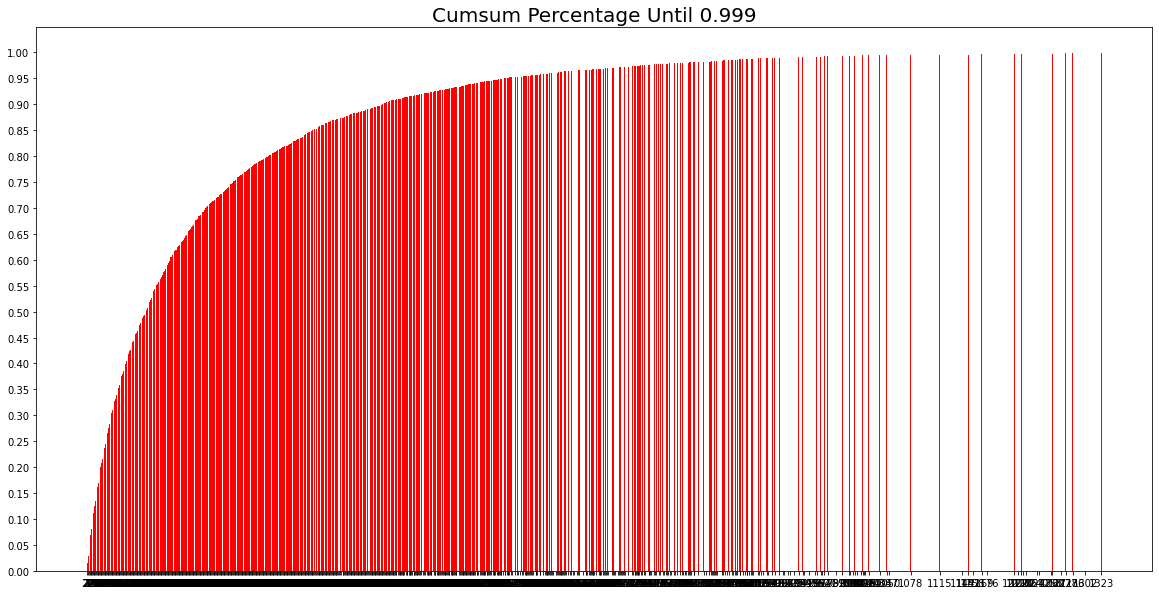

In [17]:
# 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [19]:
session_length.quantile(0.95)

556.0

In [20]:
drop_index = session_length[session_length>556].index
data.drop(index=drop_index, inplace=True)

- 95% 이상은 이상치라고 판단하고 데이터에서 삭제를 합니다.

### 1-2. Session Time
- 데이터의 시간 정보 확인 및 변경

In [23]:
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


- Time을 확인해보면 978300019 이나 978300055 으로 확인하기 어렵게 기재되어 있습니다.
- 편리한 이용을 위해서 Time의 내용을 fromtimestamp()를 이용해 변경합니다.

In [24]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [25]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


- 시간에 따른 데이터를 확인해보니, 2000년 4월 25일 부터 2003년 2월 25일 까지의 데이터가 있는 것을 확인 할 수 있습니다.

### 1-3. Data Cleansing

In [26]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [27]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 2. 미니 배치의 구성
---
- 실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다.
- Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
- 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date


In [29]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [30]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978235
	 Sessions: 6038
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12271
	 Sessions: 399
	 Items: 2606
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8805
	 Sessions: 339
	 Items: 2317
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



- Events: 데이터 갯수
- Sessions: UserId의 고유값
- Items: ItemId의 고유값
- First Time : 최소시간
- Last Time : 최대시간

In [32]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [33]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### SessionDataset

- 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [34]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [35]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [36]:
tr_dataset.click_offsets

array([     0,     52,    176, ..., 977771, 977894, 978235], dtype=int32)

In [37]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

### SessionDataLoader

In [38]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [39]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head()

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4


In [40]:
iter_ex = iter(tr_data_loader)

In [41]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 52 64 53]
Label Item Idx are :       [  1  53 171  23]
Previous Masked Input Idx are []


## Step 3. 모델 구성
---
- 이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [42]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

- 모델 성능 평가를 위한 지표

 1. Recall@k: 전체 relevant한 아이템 중 추천된 아이템이 속한 비율. 분모는 전체 relevant한 아이템의 갯수, 분자는 k개의 추천 중 relevant한 아이템의 갯수. 여기서 recall의 의미는 useful stuff에 대한 추천을 최대한 놓치지 않는 것.

 2. MRR: MRR은 Mean Reciprocal Rank의 약자. Reciprocal rank는 첫 번째로 등장하는 relevant한 아이템이 우리의 추천상 몇 번째에 위치하는지를 나타내는 지표. 하지만 그대로 몇 번째인지를 사용하면 앞에 나올 수록 좋은 모델이라는 것을 반대로 표현하게되니 역수를 취해줌.

- 출처: https://zzaebok.github.io/recommender_system/metrics/rec_metrics/

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [44]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [46]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [47]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


- 클래스의 형식으로 모델을 설계

- 한 개의 GRU layer를 사용했고, normalization을 위해 Dropout을 사용

- activation 함수로 softmax를 사용

- output이 여러개이므로, loss 함수는 categorical_crossentropy를 사용했고, optimizer는 Adam을 사용

- GRU layer: Gated Recurrent Unit의 약자. GRU는 LSTM과 비슷한 역할을 하지만, 더 간단한 구조로 이루어져 있어서 계산상으로 효율적. 기존의 LSTM에서 사용되는 셀 상태 계산(은닉 상태 업데이트)를 줄임. 특정 문제에서는 LSTM보다 더 적합한 layer.

- 출처: https://davinci-ai.tistory.com/30

## Step 4. 모델 학습
---
- 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [48]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [49]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.08]

	 - Recall@20 epoch 1: 0.098323
	 - MRR@20    epoch 1: 0.025596



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.71]

	 - Recall@20 epoch 2: 0.122332
	 - MRR@20    epoch 2: 0.033268



Evaluation:  45%|████▍     | 41/92 [00:30<00:37,  1.34it/s]

	 - Recall@20 epoch 3: 0.129954
	 - MRR@20    epoch 3: 0.037998



## Step 5. 모델 테스트
---
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [50]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  36%|███▋      | 24/66 [00:17<00:30,  1.36it/s]

	 - Recall@20: 0.138997
	 - MRR@20: 0.040757



노드에서 안내해주었던 조건으로 모델을 형성해서 테스트를 진행해보니, Recall@20: 0.138997, MRR@20: 0.040757 이라는 결과가 나왔습니다.

그러면 위에서 설정한 조건을 변경해 가면서 최적의 모델을 한 번 만들어보도록 하겠습니다.

## Step 6. 모델 개선
---

#### 6-1. 학습률 변경

1-1. lr=0.01 변경

In [51]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.46]

	 - Recall@20 epoch 1: 0.135861
	 - MRR@20    epoch 1: 0.039655



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.45]

	 - Recall@20 epoch 2: 0.136052
	 - MRR@20    epoch 2: 0.042017



Evaluation:  45%|████▍     | 41/92 [00:30<00:37,  1.36it/s]

	 - Recall@20 epoch 3: 0.138910
	 - MRR@20    epoch 3: 0.042352



In [52]:
test_model(model, args, test)

Evaluation:  36%|███▋      | 24/66 [00:17<00:30,  1.37it/s]

	 - Recall@20: 0.146484
	 - MRR@20: 0.046167



- 우선, 배치사이즈를 조정해보았으나, 너무 크면 모델 학습이 진행 되지가 않고, 반대로 배치사이즈가 작으면 텐서가 맞지 않는다는 이슈를 만들어서 처음에는 많이 당황했지만, 같이 스터디 하시는 분들의 조언으로 적절한 배치사이즈를 찾을 수 있었습니다.

- 모델 학습에 직접적인 영향을 미칠 것이라고 생각한 학습율 (=lr)을 조금 수정해 보았으나, accuracy에서나, train_loss에서 유의미한 결과값이 나오지 않은 것 같습니다.

- 그나마, 위안이 되는 것이라면 위에서 시도한 모델의 결과값보다 약간 나아졌다는 것에서 만족을 해보려고 합니다.

1-2. lr=0.1 변경

In [53]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.133, train_loss=5.37]

	 - Recall@20 epoch 1: 0.140625
	 - MRR@20    epoch 1: 0.042730



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.41]

	 - Recall@20 epoch 2: 0.140816
	 - MRR@20    epoch 2: 0.042936



Evaluation:  45%|████▍     | 41/92 [00:30<00:37,  1.36it/s]

	 - Recall@20 epoch 3: 0.142149
	 - MRR@20    epoch 3: 0.042796



In [54]:
test_model(model, args, test)

Evaluation:  36%|███▋      | 24/66 [00:17<00:30,  1.36it/s]

	 - Recall@20: 0.150065
	 - MRR@20: 0.047257



- 엄청 눈에 띄는 결과값의 변화가 있었다고 할 수 는 없겠지만,  

- 학습률 0.001 (Recall@20: 0.138997 / MRR@20: 0.040757),  
  학습률 0.01 (Recall@20: 0.146484 / MRR@20: 0.046167),  
  학습율 0.1 (Recall@20: 0.150065 / MRR@20: 0.047257)을 비교해 보니,  
  
- 0.1의 수치가 가장 좋게 나왔음을 확인 할 수 있었습니다.

#### 6-2. epochs 변경

2-1. epochs=10 변경

In [55]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.1, epochs=10, k=20)
train_model(model, args)

Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.117, train_loss=5.3] 

	 - Recall@20 epoch 1: 0.141387
	 - MRR@20    epoch 1: 0.042869



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.141, train_loss=5.31] 

	 - Recall@20 epoch 2: 0.141959
	 - MRR@20    epoch 2: 0.042448



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.33] 

	 - Recall@20 epoch 3: 0.143864
	 - MRR@20    epoch 3: 0.042347



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.117, train_loss=5.32] 

	 - Recall@20 epoch 4: 0.142721
	 - MRR@20    epoch 4: 0.041997



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.117, train_loss=5.34]

	 - Recall@20 epoch 5: 0.141387
	 - MRR@20    epoch 5: 0.042146



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.38]

	 - Recall@20 epoch 6: 0.142149
	 - MRR@20    epoch 6: 0.041333



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.34]

	 - Recall@20 epoch 7: 0.140053
	 - MRR@20    epoch 7: 0.041588



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.33] 

	 - Recall@20 epoch 8: 0.139482
	 - MRR@20    epoch 8: 0.041746



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.117, train_loss=5.26] 

	 - Recall@20 epoch 9: 0.139291
	 - MRR@20    epoch 9: 0.041592



Evaluation:  45%|████▍     | 41/92 [00:30<00:37,  1.35it/s]

	 - Recall@20 epoch 10: 0.137957
	 - MRR@20    epoch 10: 0.041113



In [56]:
test_model(model, args, test)

Evaluation:  36%|███▋      | 24/66 [00:17<00:30,  1.36it/s]

	 - Recall@20: 0.148763
	 - MRR@20: 0.048906



- epochs 값을 3에서 10으로 늘려 보았지만 성능 향상면에서 유의미한 결과를 보여주지 않았음을 확인 할 수 있었습니다.
- 아마도 epochs 말고 다른 변수를 수정해보고 진행해 봐야겠습니다.

#### 6-3. drop_rate 변경

3-1. drop_rate=0.5

In [57]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.5, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.32]

	 - Recall@20 epoch 1: 0.138529
	 - MRR@20    epoch 1: 0.040633



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.32]

	 - Recall@20 epoch 2: 0.139101
	 - MRR@20    epoch 2: 0.041024



Evaluation:  45%|████▍     | 41/92 [00:30<00:37,  1.36it/s]

	 - Recall@20 epoch 3: 0.136433
	 - MRR@20    epoch 3: 0.040609



In [58]:
test_model(model, args, test)

Evaluation:  36%|███▋      | 24/66 [00:17<00:30,  1.37it/s]

	 - Recall@20: 0.151042
	 - MRR@20: 0.048602



3-2. drop_rate=0.9

In [59]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.9, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.31]

	 - Recall@20 epoch 1: 0.136814
	 - MRR@20    epoch 1: 0.040458



Train:   0%|          | 0/7595 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.3] 

	 - Recall@20 epoch 2: 0.136242
	 - MRR@20    epoch 2: 0.040455



Evaluation:  45%|████▍     | 41/92 [00:30<00:37,  1.35it/s]

	 - Recall@20 epoch 3: 0.137576
	 - MRR@20    epoch 3: 0.040346



In [60]:
test_model(model, args, test)

Evaluation:  36%|███▋      | 24/66 [00:17<00:30,  1.36it/s]

	 - Recall@20: 0.151042
	 - MRR@20: 0.048314



- drop_rate 0.1 (Recall@20: 0.138997 / MRR@20: 0.040757),  
  drop_rate 0.5 (Recall@20: 0.151042 / MRR@20: 0.048602),  
  drop_rate 0.9 (Recall@20: 0.151042 / MRR@20: 0.048314)을 비교해 보니,  
  
- epochs 수가 낮아서 그런지 drop_rate 여부가 크게 기여하지 않는 것으로 추정됩니다.

- 그래도 그나마 drop_rate 가 0.5 일 때 Recall@20 / MRR@20에서 상대적으로 높은 결과값을 보임을 확인 할 수 있었습니다.

## Step 7. 루브릭 & 회고
---

### 루브릭
---
아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항 & 상세기준

1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
- 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.

2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
- 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.

3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
- 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

### 회고

- 지금까지 해온 프로젝트에 비해서 결과 값의 수치가 너무 맞게 느껴져서 프로젝트 진행이 쉽지 않았던 것 같습니다.

- 그럼에도 불구하고 프로젝트를 진행하면서 제가 느낀 점에 대해서 적어보자면,

- 우선, 모델 학습 과정에서 배치사이즈를 조정해보았으나, 너무 크면 모델 학습이 진행 되지가 않고, 반대로 배치사이즈가 작으면 텐서가 맞지 않는다는 이슈가 나와 처음에는 많이 당황했었지만, 같이 스터디 하시는 분들의 조언으로 나름대로 적절한 배치사이즈(= 128)를 찾을 수 있었습니다.

- 모델 학습에 직접적인 영향을 미칠 것이라고 생각한 변수 (학습율, epochs, drop_rate) 을 조금 수정해 보았으나, accuracy에서나, train_loss에서 유의미한 결과값이 나왔는지에 대한 여부나 개선이 되었는지 그렇지 않았는지를 제가 판별하기가 어려웠던 것 같습니다.

- 그나마, 위안이 되는 것이라면 처음에 시도한 모델 테스트의 결과값 (Recall@20: 0.138997 / MRR@20: 0.040757) 보다 학습율 = 0.1, epochs = 3, drop_rate = 0.5 으로 수정한 뒤에 진행한 모델의 테스트 결과값 (Recall@20: 0.151042 / MRR@20: 0.048314)이 약간 이나마 나아졌다는 것에서 만족을 해보려고 합니다.

- 항상 느끼는 것이지만, 다양한 시도를 하고 싶다는 생각이 있긴 하지만 노드에 투자 할 수 있는 시간이 한정 되어 있어서 그렇지 못한다는 사실이 너무 아쉬움을 느낍니다.

### 참고 레퍼런스

- https://zzaebok.github.io/recommender_system/metrics/rec_metrics/

- https://davinci-ai.tistory.com/30